In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
%pylab inline
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization, SeparableConv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import pickle

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

Populating the interactive namespace from numpy and matplotlib


True

In [0]:
X = pickle.load(open('/content/drive/My Drive/brain tumor/X.pickle','rb'))

In [0]:
y = np.load('/content/drive/My Drive/brain tumor/y.npy')

In [63]:
each_pixel_mean = X.mean(axis=0)
each_pixel_std = np.std(X, axis=0)
images = np.divide(np.subtract(X,each_pixel_mean), each_pixel_std)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
X.shape

(3064, 256, 256, 1)

In [0]:
X = X.astype('float32')
y = to_categorical(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle = False)

In [0]:
'''
def architecture(input_shape, num_classes, l2_regularization=0.001):
    regularization = l2(l2_regularization)

    
    img_input = Input(input_shape)
    
    #Base block
    x = Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=regularization, use_bias=False)(img_input)
    residual_base = x
    residual_base_128 = tf.reshape(residual_base, shape=[-1, 256, 256, 128])
    residual_base_256 = tf.reshape(residual_base, shape=[-1, 256, 256, 256])
    residual_base_512 = tf.reshape(residual_base, shape=[-1, 256, 256, 512])
    
    #First residual block
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=regularization, use_bias=False)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=regularization, use_bias=False)(x)
    residual_1 = x 
    residual_1_128 = tf.reshape(residual_1, shape=[-1, 256, 256, 128])
    residual_1_256 = tf.reshape(residual_1, shape=[-1, 256, 256, 256])
    residual_1_512 = tf.reshape(residual_1, shape=[-1, 256, 256, 512])
   
    #Second residual block
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    residual_2 = x
    residual_2_256 = tf.reshape(residual_1, shape=[-1, 256, 256, 256])
    residual_2_512 = tf.reshape(residual_1, shape=[-1, 256, 256, 512])

    x = layers.add([x,residual_1_128])
    

    #Third residual block
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', use_bias=False)(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same',  activation='relu', use_bias=False)(x)
    residual_3 = x
    residual_3_512 = tf.reshape(residual_3, shape=[-1, 256,256,512])
    x = layers.add([x, residual_2_256])
    
    #Fourth residual block
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same',  activation='relu', use_bias=False)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', use_bias=False)(x)
    x = layers.add([x, residual_3_512])
    
    x = GlobalAveragePooling2D()(x)
   
    
    output = Dense(units=3, activation='softmax')(x)
    

    model = Model(img_input, output)
    model.summary()
    return model
'''

In [0]:
def architecture(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    
    img_input = Input(input_shape)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=regularization, use_bias=False)(img_input)
    #x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    #x = Dropout(0.10)(x)
    
    residual_1 = MaxPooling2D()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    #x = Dropout(0.10)(x)
    x = MaxPooling2D()(x)
    x = layers.add([x,residual_1])
    
    residual_2 = x
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    #x = Dropout(0.10)(x)
    x = MaxPooling2D()(x)
    x = layers.add([x, residual_1, residual_2])
    
    residual_3 = MaxPooling2D()(x)
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    #x = Dropout(0.10)(x)
    x = MaxPooling2D()(x)
    x = layers.add([x, residual_1, residual_2, residual_3])
    
    
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = GlobalAveragePooling2D()(x)
    #y = GlobalAveragePooling2D()(residual_1)
    #z = GlobalAveragePooling2D()(residual_2)

    #x_y_z = layers.add([x,y,z])
    
    
    output = Dense(units=3, activation='softmax')(x)
    

    model = Model(img_input, output)
    model.summary()
    return model
    

In [0]:
def architecture(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    
    img_input = Input(input_shape)
    x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=regularization, use_bias=False)(img_input)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    residual_1 = x

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', use_bias=False)(x)
    x = Dropout(0.10)(x)
    x = layers.add([x,residual_1])
    
    residual_2 = x
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Dropout(0.10)(x)
    x = layers.add([x, residual_1, residual_2])
    
    residual_3 = x
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    x = Dropout(0.10)(x)
    x = layers.add([x, residual_1, residual_2, residual_3])
    
    
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, activation='relu', use_bias=False)(x)
    
    """
    x = GlobalAveragePooling2D()(x)
    #y = GlobalAveragePooling2D()(residual_1)
    #z = GlobalAveragePooling2D()(residual_2)

    #x_y_z = layers.add([x,y,z])
    """
    x =Flatten()(x)
    
    output = Dense(units=3, activation='softmax')(x)
    

    model = Model(img_input, output)
    model.summary()
    return model
    

In [67]:
'''
#ALEXNET ARCHITECTURE
np.random.seed(1000)

# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (4, 4), activation='relu', padding = 'valid', input_shape=(256,256,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (4, 4), activation='relu', padding = 'valid', input_shape=(256,256,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
'''

"\n#ALEXNET ARCHITECTURE\nnp.random.seed(1000)\n\n# Constructing CNN structure\nmodel = Sequential()\n\n# 1st convolution layer\nmodel.add(Conv2D(64, (4, 4), activation='relu', padding = 'valid', input_shape=(256,256,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))\nmodel.add(Conv2D(64, (4, 4), activation='relu', padding = 'valid', input_shape=(256,256,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))\nmodel.add(Dropout(0.25))\n\n# 3rd convolution layer\nmodel.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))\nmodel.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(

In [72]:
input_shape = X.shape[1:]
num_classes = 3
model = architecture(input_shape, num_classes=3)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 128 3200        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 128, 128, 128 0           max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [0]:
filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [0]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=16),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0],
                    callbacks=[checkpointer,tensorboard]
                             )


pd.DataFrame(history.history).to_csv("history.csv")

Epoch 1/10
 644/1500 [===========>..................] - ETA: 13s - loss: 1.2596 - acc: 0.4612
Epoch 00001: val_loss improved from inf to 1.25655, saving model to Model.01-0.4612.hdf5
1500/1500 [==============================] - 1302s 868ms/step - loss: 3.5061 - acc: 0.4515 - val_loss: 1.2566 - val_acc: 0.4612
Epoch 2/10
 644/1500 [===========>..................] - ETA: 12s - loss: 1.2300 - acc: 0.4612
Epoch 00002: val_loss improved from 1.25655 to 1.22674, saving model to Model.02-0.4612.hdf5
1500/1500 [==============================] - 1298s 865ms/step - loss: 1.5912 - acc: 0.4552 - val_loss: 1.2267 - val_acc: 0.4612
Epoch 3/10
 644/1500 [===========>..................] - ETA: 12s - loss: 1.2136 - acc: 0.4612
Epoch 00003: val_loss improved from 1.22674 to 1.21036, saving model to Model.03-0.4612.hdf5
1500/1500 [==============================] - 1298s 866ms/step - loss: 1.6244 - acc: 0.4558 - val_loss: 1.2104 - val_acc: 0.4612
Epoch 4/10
 644/1500 [===========>..................] - ETA

In [0]:
model2 = load_model('Model.05-0.4791.hdf5')

In [0]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=16)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

920/920 [==============================] - 12s 13ms/sample - loss: 1.0533 - acc: 0.4837
Loss: 1.0532933297364608
Accuracy: 0.48369566


In [0]:
history = pd.read_csv('history.csv', usecols = ['acc','loss','val_acc','val_loss'])

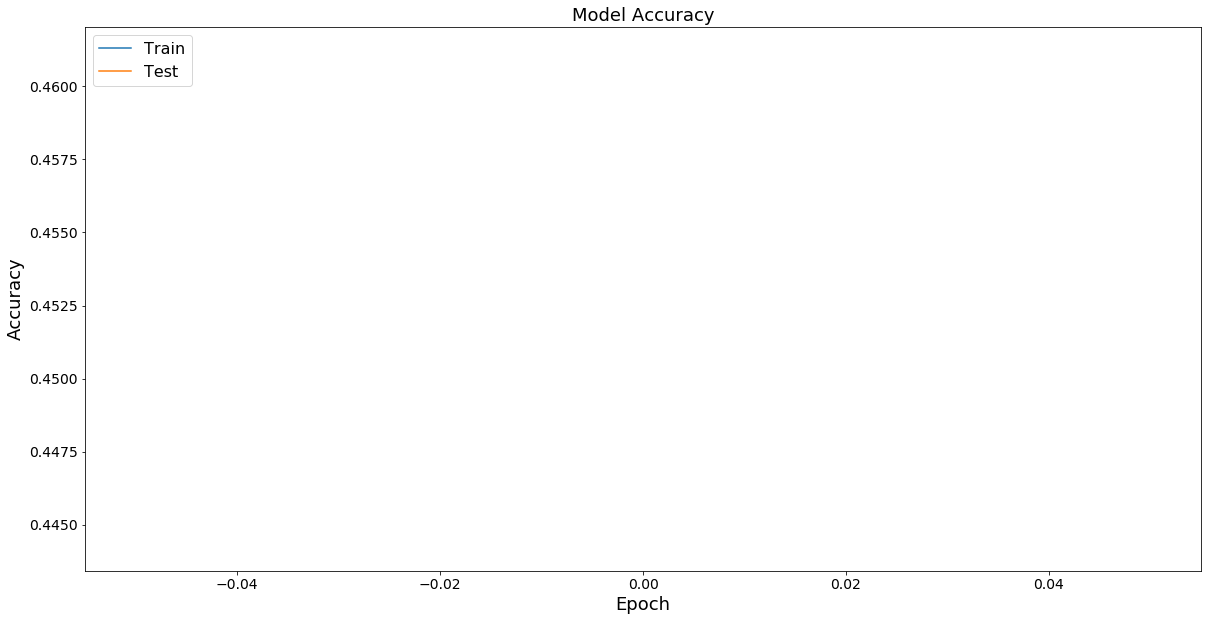

In [0]:
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['acc'])
    plt.plot(data['val_acc'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history)

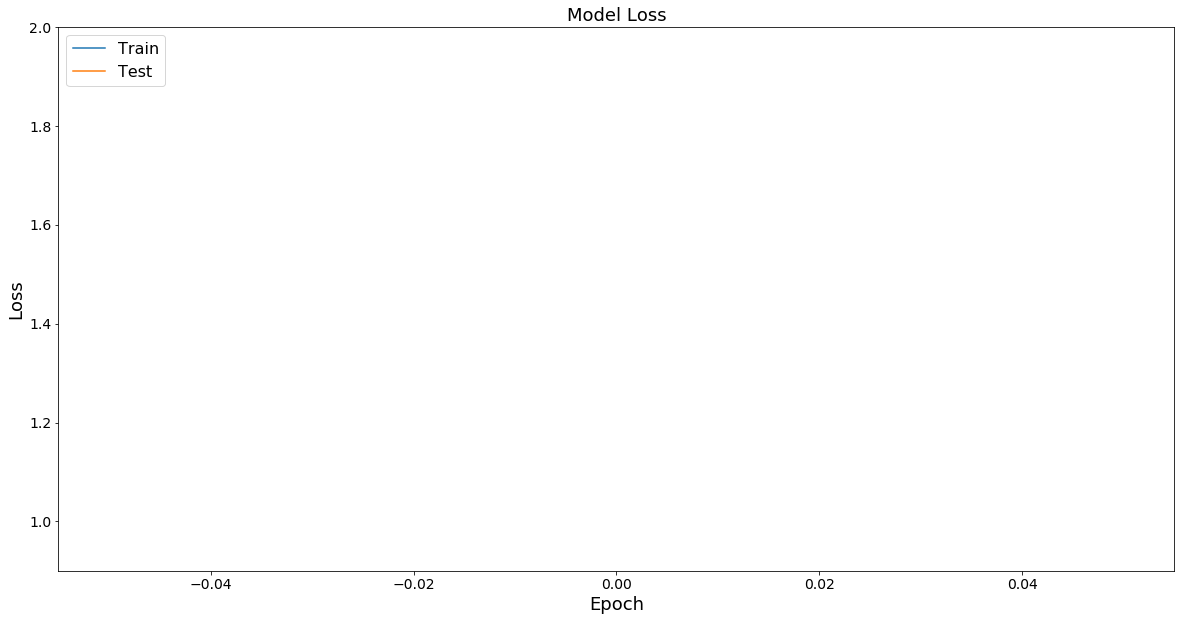

In [0]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)

In [0]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

In [0]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['GLIOMA','MENINGIOMA','PITUITARY'], colour = 'Greens')

NameError: ignored